# Utilizing SHAP to Measure Motif Effect

This notebook contains the code needed to generate the feature importance of motifs from select proteins. We wish to measure the correlation between the Mean RNA Bind Protein (MeanRBP) value of a motif and its effect on expression rate (ER). We hypothesize that motifs with high *MeanRBP* will also have high *feature importance*, thus having a motif with a high MeanRPB will have a higher effect on the ER. To do this, we train an XGBoost Regressor on protein degredation data and use SHAP values to extract the feature importance of each motif. We then plot this against MeanRBP and measure their Pearson Correlation Coefficient. 

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# Generating the dataset

In [85]:
#given a RPBScan, return the top n motifs
def get_top_motifs(rbp_file, n):
    top_motifs = []
    rbp_df = pd.read_csv("data/mean_rbp_data/"+rbp_file+".csv")[['Motif', 'Mean_RBP']].sort_values(by='Mean_RBP')
    top_motifs = rbp_df.nlargest(n, 'Mean_RBP')['Motif'].tolist()

    #replace U with T
    updated_words = [word.replace('U', 'T') for word in top_motifs]

    #for Pum1 and Ago2, add A at the end
    if rbp_file=="ZF_7N_drePum1" or rbp_file=="ZF_7N_dreAgo2":
        updated_words = [word+"A" for word in updated_words]
    return updated_words

In [86]:
#given top motifs, returns a df containing only sequences containing motifs
def get_separate_df(motif_list):
    seqs = pd.read_csv("data/Rabani_oligos.csv")
    new_df = pd.DataFrame(columns=seqs.columns)
    for ind in seqs.index:
        seq = seqs.iloc[ind]["Sequence"]
        if any(motif in seq for motif in motif_list):
            new_df.loc[len(new_df)] = seqs.iloc[ind]
    return new_df 

In [87]:
#create dictionary
df = pd.read_csv("data/AGTC-7seq.csv", header = None)
data_arr = np.array(df).flatten()
motif_dict = {data_arr[i]: 0 for i in range(0, len(data_arr))}

In [88]:
#window-size = 7
def count_based_encoding(seq: str, motif_dict: dict) -> list:
    for i in range(len(seq)-6):
        sub_seq = seq[i:i+7]
        motif_dict[sub_seq] += 1
    encoding_out = pd.DataFrame.from_dict([motif_dict])
    return encoding_out

In [89]:
#creates individual datasets for each protein
def format_data(motif_dict, starting_index, rbp_data):
    exp_data = pd.read_csv("data/Rabani_expression_A+.csv")
    top_motifs = get_top_motifs(rbp_data, 10)
    print(top_motifs)
    seq_data = get_separate_df(top_motifs)
    print("Found motifs in "+ str(len(seq_data))+ " sequences")
    #generate ER
    df = None
    if starting_index == 0:
        df = pd.DataFrame.from_dict([motif_dict])
        df.insert(loc = 0, column="Sequence", value=None)
        df["ER"] = [0]
        df = df.iloc[1:0]
    else:
        df = pd.read_csv("data/seq_er.csv")
    # Slice the DataFrame from the starting index onward
    for ind, row in seq_data.iloc[starting_index:].iterrows():
        seq = seq_data.loc[ind, 'Sequence'] 
        seq_id = seq_data.loc[ind, 'id'] 
        #see if sequence is in seq_data
        if len(seq) !=0:
            er = (exp_data.loc[exp_data['id'] == seq_id, '8h'].values - exp_data.loc[exp_data['id'] == seq_id, '1h'].values)/2
            new_row = count_based_encoding(seq, motif_dict.copy())
            new_row.insert(loc = 0, column="Sequence", value=[seq])
            new_row["ER"] = er
            df = pd.concat([df,new_row], ignore_index=True)
            print(ind)
            if ind%4000==0:
                df.to_csv("data/seq_er/"+rbp_data+"_seq_er.csv", index=False)
                print("saved at "+str(ind))
    df.to_csv("data/seq_er/"+rbp_data+"_seq_er.csv", index=False)
    print("saved at"+str(ind))

In [90]:
proteins = [
    "dreAgo2", 
    "dreCth1", 
    "dreG3BP1", 
    "drehnRNPA0a",
    "drehnRNPD", 
    "dreHuR", 
    "drePum1", 
    "drePurB", 
    "PCBP2"
    ]
for protein in proteins:
    format_data(motif_dict, 0, protein)

['AGATGGG', 'TGAAGGT', 'GAAGGGG', 'TGAGGGT', 'AGAAGGG', 'AGAGGGA', 'AGAAGGT', 'AGAGGGG', 'TGAGGGG', 'GAAAGGG']
Found motifs in 4642 sequences
0
saved at 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
2

# Loading the Dataset

In [ ]:
#for feature reduction
def get_kept_features():
    feature_df = pd.read_csv("data/feature_importance.csv")
    motif_keep_list = []
    for ind, row in feature_df.iterrows():
        if feature_df["importance"][ind] > 0:
            motif_keep_list.append(feature_df["feature"][ind])
    return motif_keep_list

In [100]:
#choose a specific protein for the model to train on
protein = "PCBP2"
#prepare the data
df = pd.read_csv("data/seq_er/"+protein+"_seq_er.csv")

X = df.drop(columns=["Sequence", "ER"]) 

Y = df['ER']

res = train_test_split(X, Y, 
                       train_size=0.8,
                       test_size=0.2,
                       random_state=1)
X_train, X_test, Y_train, Y_test = res 

# Model for Linear Regression (one out)

In [101]:
#We create a dictionary that contains our model hyperparameters
xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.001,
    'subsample': 0.5,
    'alpha': .1,
    'max_depth': 16,
    'colsample_bytree' : .8,
    'min_child_weight': 1,
    'scale_pos_weight': 10,
    'objective': 'reg:squarederror',
    'device' : "cuda"
}

In [102]:
#Train the XGBoost model
xgb_model = XGBRegressor(**xgb_params)
xgb_model = xgb_model.fit(X_train, Y_train)
xgb_model.save_model("models/"+protein+"_model.json")

/restricted/projectnb/cifulab/Sam/SHAP_Regressor/.venv/lib64/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:36:47] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/restricted/projectnb/cifulab/Sam/SHAP_Regressor/.venv/lib64/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:36:47] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


In [103]:
xgb_model.load_model("models/"+protein+"_model.json")
#Making predictions on the test set
predictions = xgb_model.predict(X_test)

# Calculate the mean squared error and R-squared score
rmse = root_mean_squared_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)
r = np.corrcoef(Y_test, predictions)[0][1]

print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)
print("Pearson Corr Coef:", r)

Root Mean Squared Error: 0.526679322914453
R-squared Score: 0.08183142166852198
Pearson Corr Coef: 0.5223501195337739


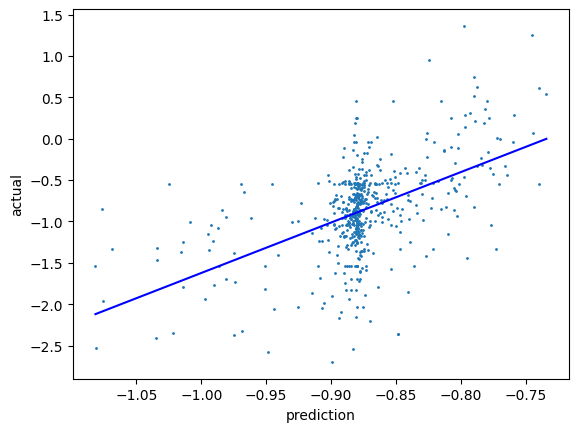

In [104]:
plt.scatter(predictions, Y_test, s = 1)
plt.xlabel("prediction")
plt.ylabel("actual")
plt.plot(np.unique(predictions), np.poly1d(np.polyfit(predictions, Y_test, 1))(np.unique(predictions)), color = 'blue')
plt.show()

# Model for Polinomial Regression

Rather than train on a general expression rate, this model trains of the whole expression curve, leading to stronger outputs and more correlation. 

In [ ]:
#Creating the Dataset (don't need to run again)
#instead of using ER, we use an array of expressions at hour h:[1h,2h,3h,4h,5h,6h,7h,8h]
def create_poli_seq_er():
    df = pd.read_csv("data/seq_er.csv")
    exp_data = pd.read_csv("data/Rabani_expression_A+.csv")
    seq_data = pd.read_csv("data/Rabani_oligos.csv")
    poli_er = []
    for sequence in df["Sequence"]:
        #sequence to id
        id = seq_data.loc[seq_data['Sequence'] == sequence, ["id"]].values[0][0]
        row = exp_data.loc[exp_data['id'] == id, ["1h","2h","3h","4h","5h","6h","7h","8h","10h"]]
        poli_er.append(row.values.flatten().tolist())
    df["poli_er"]= poli_er
    df.drop('ER', axis=1, inplace=True)
    df.to_csv("poli_seq_er.csv")

In [ ]:
poli_df = pd.read_csv("data/poli_seq_er.csv")

In [ ]:
X = poli_df.drop(columns=["Sequence", "poli_er"]) 
Y = list(poli_df["poli_er"].apply(ast.literal_eval))
res = train_test_split(X, Y, 
                       train_size=0.8, 
                       test_size=0.2, 
                       random_state=1) 

X_, X_test, Y_, Y_test = res 

res = train_test_split(X_, Y_, 
                       train_size=0.8, 
                       test_size=0.2, 
                       random_state=1) 

X_train, X_eval, Y_train, Y_eval = res

In [ ]:
def plot_predt(y: np.ndarray, y_predt: np.ndarray, name: str) -> None:
    s = 2
    x_l = [1,2,3,4,5,6,7,8,10]
    for i in range(len(y)):
        #plot ground truth
        plt.scatter(x_l, y[i], c="navy", s=s, label="data", marker='s')
        plt.plot(x_l, y[i], c="navy", label="data")

        #plot prediction
        plt.scatter(x_l, y_predt[i],  c="cornflowerblue", s=s, marker='x')
        plt.plot(x_l, y_predt[i],  c="cornflowerblue")
    plt.show()

In [ ]:
def rmse_model(plot_result: bool, strategy: str) -> None:
    # Train a regressor on it
    reg = XGBRegressor(
        tree_method="hist",
        n_estimators=16384,
        n_jobs=16,
        max_depth=32,
        multi_strategy=strategy,
        subsample=0.5,
        learning_rate = 0.001,
        alpha = .1,
        colsample_bytree = .8,
        scale_pos_weight= 10,
        device = "cuda"
    )
    reg.fit(X_train, Y_train, eval_set=[(X_eval, Y_eval)])
    reg.save_model("multi_reg.json")

In [ ]:
rmse_model(False, "one_output_per_tree")

In [ ]:
reg = XGBRegressor(
        tree_method="hist",
        n_estimators=1000,
        n_jobs=16,
        max_depth=16,
        multi_strategy="one_output_per_tree",
        subsample=0.5,
        learning_rate = 0.001,
        alpha = .1,
        colsample_bytree = .8,
        scale_pos_weight= 10,
        device = "cuda"
    )
reg.load_model("multi_reg_test.json")
y_predt = reg.predict(X_test)
# Calculate the mean squared error and R-squared score

In [ ]:
window = 3
rand = np.random.randint(len(Y_test)-window)
plot_predt(Y_test[rand:rand+window], y_predt[rand:rand+window], "multi")

In [ ]:
rmse = root_mean_squared_error(Y_test, y_predt)
r2 = r2_score(Y_test, y_predt)

print("Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# SHAP values

Now, we use shap values to examine the feature importance of each motif. Many of these cells just output visualizations of the data, so they are not needed for the final process. 

In [105]:
#We are going to explain the xgboost model
#Since both algorithls are tree based we are going to use Tree explainer, a fast implementation to compute
#Shap values when models are tree based
#load the xgb_model
xgb_model = XGBRegressor(**xgb_params)
xgb_model.load_model("models/"+protein+"_model.json")

explainer = shap.TreeExplainer(xgb_model, X, model_output = "raw")
shap_values = explainer.shap_values(X)

100%|===================| 2769/2778 [01:45<00:00]        

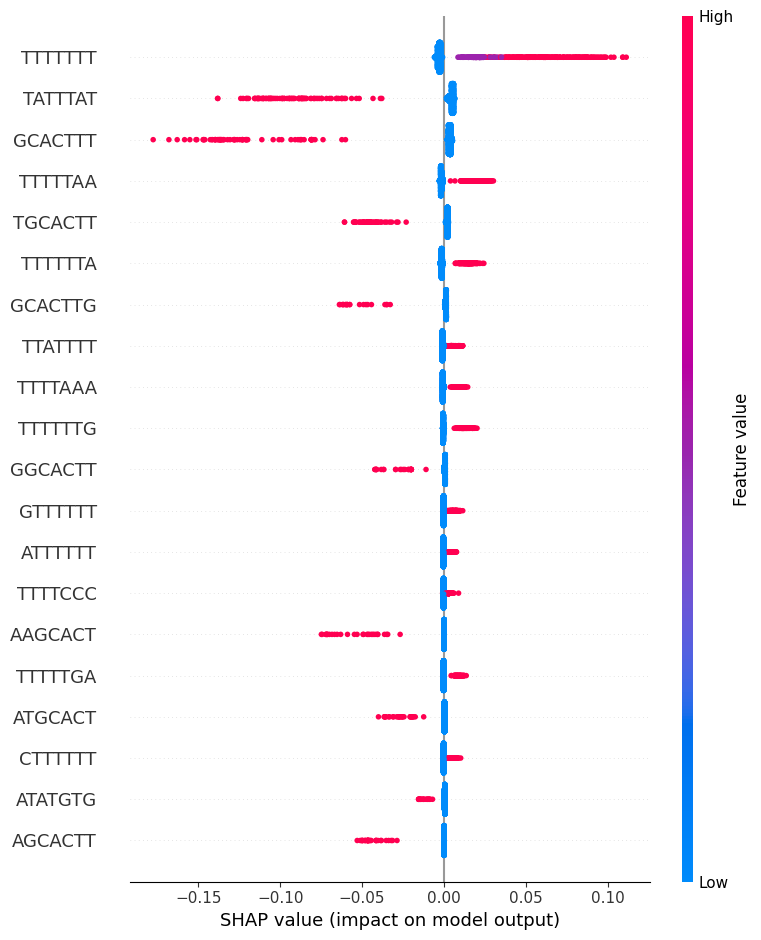

In [106]:
shap.summary_plot(shap_values, X, show=False)
plt.savefig("plots/"+protein+'_shap.svg')
plt.show()

In [ ]:
shap.initjs()
client_index = 0
shap.force_plot(explainer.expected_value, shap_values[client_index,:], X.iloc[client_index,:])

In [ ]:
shap_explainer = explainer(X)
shap.plots.bar(shap_explainer)

In [ ]:
shap.plots.bar(shap_explainer[client_index])

In [ ]:
shap.plots.heatmap(shap_explainer, max_display = 20)

In [ ]:
explanation = explainer(X[:1000])
shap.plots.scatter(explanation[:,"AGCACTT"], color = explanation)

# Feature Importance
We'll want to save the feature importance for later on. 

In [107]:
#save dataframe for feature reduction
feature_df = pd.DataFrame({'feature': X.columns, 'importance': np.abs(shap_values).mean(0)})
feature_df = feature_df.sort_values('importance', ascending=False)
feature_df.to_csv('data/feature_importance/'+protein+"_feature_importance.csv", index=False)  

# Feature Importance to Mean RBP
The goal of this project is to measure the importance of RNA binding protiens in expression rate. To do this, we rank the motifs by expression rate, as well as feature importance, and measure the correlation. 

In [27]:
def retain_common_keys(dict1, dict2):
    # Filter dictionaries to retain only common keys, preserving the order of dict1
    dict1 = {k: dict1[k] for k in dict1 if k in dict2}
    dict2 = {k: dict2[k] for k in dict1}
    
    return dict1, dict2

In [ ]:
#takes an RBP file, plots and prints r^2
def get_rbp_comparison(rbp_file, sample):
    #get dataframes
    rbp_df =pd.read_csv("data/mean_rbp_data/"+rbp_file+".csv")[['Motif', 'Mean_RBP']]
    feature_df = pd.read_csv("data/feature_importance/"+rbp_file+"_feature_importance.csv")
    #convert all Us to Ts in rbp_dfs:
    rbp_df['Motif'] = rbp_df['Motif'].apply(lambda s: s.replace("U", "T"))
    # Sort by feature importance
    rbp_df = rbp_df.sort_values('Mean_RBP', ascending=False)
    #df to dict
    feature_dict = dict(zip(feature_df['feature'], feature_df['importance']))
    rbp_dict = dict(zip(rbp_df['Motif'], rbp_df['Mean_RBP']))
    #make dict intersection, reordering with respect to first parameter (rbp_dict)
    ordered_rbp, feature_dict = retain_common_keys(rbp_dict,feature_dict)
    #convert to lists of value and key (for scatter plot labeling)
    rbp_keys = list(ordered_rbp.keys())[:sample] 
    rbp_value = list(ordered_rbp.values())[:sample] 
    feature_value = list(feature_dict.values())[:sample]
    #plot
    plt.scatter(rbp_value,feature_value, s = 4)
    plt.plot(np.unique(rbp_value), np.poly1d(np.polyfit(rbp_value,feature_value, 1))(np.unique(rbp_value)), color = 'blue')
    for i in range(len(rbp_value)):
        plt.text(rbp_value[i], feature_value[i], str((i+1))+":"+rbp_keys[i])
    plt.xlabel(rbp_file+" values")
    plt.ylabel("feature values")
    plt.title(rbp_file+" Correlation Plot")
    mse = root_mean_squared_error(rbp_value, feature_value)
    r = np.corrcoef(rbp_value, feature_value)[0][1]
    plt.plot([], [], ' ', label="Mean Squared Error for "+rbp_file+": "+str(mse))
    plt.plot([], [], ' ', label="Pearson Corr Coeff (R) for "+rbp_file+": "+str(r))
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.3))
    plt.savefig("plots/"+rbp_file+".svg", bbox_inches='tight')
    plt.show()
    
    print("Mean Squared Error for "+rbp_file+":", mse)
    print("Pearson Corr Coeff (R) for "+rbp_file+":", r)

In [ ]:
def get_bind_n_seq_comparison(sample):
    #get dataframes
    bind_n_seq_df = pd.read_csv("data/Enrichments.csv")[['Sequence', 'ENCFF266PHU']]
    feature_df = pd.read_csv("data/feature_importance.csv")
    # Sort by feature importance
    feature_df = feature_df.sort_values('importance', ascending=False)
    bind_n_seq_df = bind_n_seq_df.sort_values('ENCFF266PHU', ascending=False)
    #df to dict
    feature_dict = dict(zip(feature_df['feature'], feature_df['importance']))
    bind_n_seq_dict = dict(zip(bind_n_seq_df['Sequence'], bind_n_seq_df['ENCFF266PHU']))
    #convert from importance to rank
    feature_dict = {key: index + 1 for index, key in enumerate(feature_dict)}
    bind_n_seq_dict = {key: index + 1 for index, key in enumerate(bind_n_seq_dict)}
    #make dict intersection, reordering with respect to first parameter (feature_dict)
    bind_n_seq_dict, feature_dict = retain_common_keys(bind_n_seq_dict,feature_dict)
    #convert to list
    feature_values = list(feature_dict.values())[:sample]
    bind_n_seq_values = list(bind_n_seq_dict.values())[:sample]
    #plot
    plt.scatter(bind_n_seq_values, feature_values, s = 4)
    plt.xlabel("bind n seq values")
    plt.ylabel("feature_values")
    plt.title("Bind n Seq Correlation Plot")
    plt.plot(np.unique(bind_n_seq_values), np.poly1d(np.polyfit(bind_n_seq_values, feature_values, 1))(np.unique(bind_n_seq_values)), color = 'red')
    mse = root_mean_squared_error(bind_n_seq_values, feature_values)
    r = np.corrcoef(bind_n_seq_values, feature_values)[0][1]
    plt.plot([], [], ' ', label="Mean Squared Error for bind n seq: "+str(mse))
    plt.plot([], [], ' ', label="Pearson Corr Coeff (R) for bind n seq: "+str(r))
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.3))
    plt.savefig("plots/bindnseq.png", bbox_inches='tight')
    plt.show()
    #calc mse, r2
   
    print("Mean Squared Error for bind n seq: ", mse)
    print("Pearson Corr Coeff (R) for bind n seq: ", r)

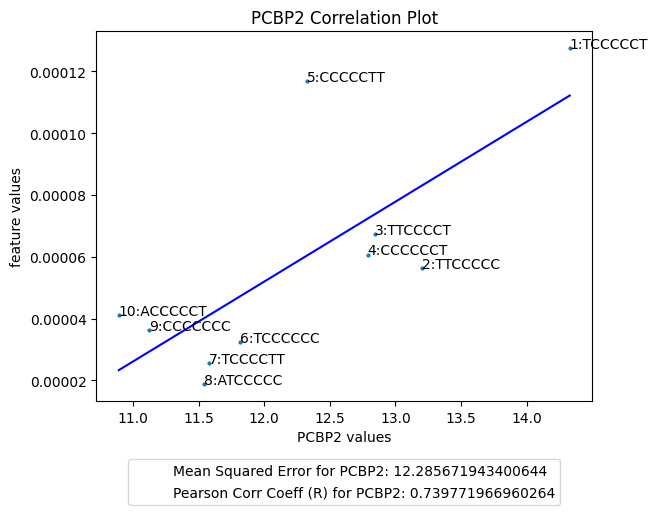

Mean Squared Error for PCBP2: 12.285671943400644
Pearson Corr Coeff (R) for PCBP2: 0.739771966960264


In [108]:
get_rbp_comparison(protein, 10)